# Alzheimer's Disease Brain Gene Expression Analysis

**Author:** Collin McNeil  
**Course:** BIN602: Data Mining for Bioinformatics  
**Date:** January 2026

## Research Questions

1. **Binary Classification:** Can we distinguish Alzheimer's disease from healthy controls using gene expression?
2. **Severity Prediction:** Can we predict disease severity (Braak stage) in AD patients?
3. **Molecular Subtypes:** Are there distinct molecular subtypes within AD patients?
4. **Cognitive Decline:** Can we predict cognitive function (MMSE scores) from gene expression?

## Dataset Overview

- **Total samples:** 253 (80 AD patients, 173 healthy controls)
- **Data source:** GEO accession GSE48350
- **Tissue:** Post-mortem brain tissue from 4 regions
- **Platform:** Affymetrix microarray

---
## 1. Setup and Imports

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GEOparse

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


---
## 2. Load Data

We'll load both the gene expression data and the cleaned metadata.

In [18]:
# Load cleaned metadata
metadata = pd.read_csv('../data/sample_metadata_clean.csv')

print(f"Loaded metadata for {len(metadata)} samples")
print(f"\nDisease breakdown:")
print(metadata['disease_status'].value_counts())

# Display first few rows
metadata.head()

Loaded metadata for 253 samples

Disease breakdown:
disease_status
Control    173
AD          80
Name: count, dtype: int64


,sample_id,title,individual,brain region,gender,age (yrs),braak stage,apoe genotype,mmse,disease_status,brain_region_clean,braak_stage_clean,mmse_clean,age_numeric,include_binary_classification,include_severity_prediction,include_mmse_regression,include_clustering
0,GSM300166,PostcentralGyrus_female_91yrs_indiv10,"10, C",postcentral gyrus,female,91,NaN,NaN,NaN,Control,post-central gyrus,NaN,NaN,91,True,False,False,False
1,GSM300167,SuperiorFrontalGyrus_female_91yrs_indiv10,"10, C",superior frontal gyrus,female,91,NaN,NaN,NaN,Control,superior frontal gyrus,NaN,NaN,91,True,False,False,False
2,GSM300168,Hippocampus_female_96yrs_indiv105,"105, C",hippocampus,female,96,NaN,NaN,NaN,Control,hippocampus,NaN,NaN,96,True,False,False,False
3,GSM300169,Hippocampus_male_82yrs_indiv106,"106, C",hippocampus,male,82,NaN,NaN,NaN,Control,hippocampus,NaN,NaN,82,True,False,False,False
4,GSM300170,Hippocampus_male_84yrs_indiv108,"108, C",hippocampus,male,84,NaN,NaN,NaN,Control,hippocampus,NaN,NaN,84,True,False,False,False


In [19]:
# Load GEO dataset with expression data
print("Loading gene expression data from GEO (this may take a minute)...")
gse = GEOparse.get_GEO(geo="GSE48350", destdir="../data")

# Extract expression matrix
# The expression data is in the table of each sample (gsm)
# We'll use the normalized values
print("\nExtracting expression matrix...")

# Get the first sample to see structure
first_sample = list(gse.gsms.keys())[0]
print(f"Sample structure example: {first_sample}")
print(f"Columns available: {gse.gsms[first_sample].table.columns.tolist()}")

16-Jan-2026 16:26:43 DEBUG utils - Directory ../data already exists. Skipping.
16-Jan-2026 16:26:43 INFO GEOparse - File already exist: using local version.
16-Jan-2026 16:26:43 INFO GEOparse - Parsing ../data/GSE48350_family.soft.gz: 
16-Jan-2026 16:26:43 DEBUG GEOparse - DATABASE: GeoMiame
16-Jan-2026 16:26:43 DEBUG GEOparse - SERIES: GSE48350
16-Jan-2026 16:26:43 DEBUG GEOparse - PLATFORM: GPL570


Loading gene expression data from GEO (this may take a minute)...


/Users/collinmcneil/Desktop/bin602-final/venv/lib/python3.14/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
16-Jan-2026 16:26:44 DEBUG GEOparse - SAMPLE: GSM300166
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300167
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300168
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300169
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300170
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300171
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300172
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300173
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300174
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300175
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300176
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300177
16-Jan-2026 16:26:45 DEBUG GEOparse - SAMPLE: GSM300178
16-Jan-2026


Extracting expression matrix...
Sample structure example: GSM300166
Columns available: ['ID_REF', 'VALUE', 'PLIER']


In [20]:
# Build expression matrix
# For each sample, extract the VALUE column (normalized expression)
expression_data = {}

for gsm_name, gsm in gse.gsms.items():
    # Get the expression values - usually in 'VALUE' or 'PLIER' column
    if 'VALUE' in gsm.table.columns:
        expression_data[gsm_name] = gsm.table['VALUE'].values
    elif 'PLIER' in gsm.table.columns:
        expression_data[gsm_name] = gsm.table['PLIER'].values

# Get probe IDs from first sample
probe_ids = gse.gsms[first_sample].table['ID_REF'].values

# Create dataframe: rows = probes/genes, columns = samples
expression_df = pd.DataFrame(expression_data, index=probe_ids)

print(f"\nExpression matrix shape: {expression_df.shape}")
print(f"Number of probes: {expression_df.shape[0]}")
print(f"Number of samples: {expression_df.shape[1]}")

# Display first few rows and columns
expression_df.iloc[:5, :5]


Expression matrix shape: (54675, 253)
Number of probes: 54675
Number of samples: 253


,GSM300166,GSM300167,GSM300168,GSM300169,GSM300170
1007_s_at,0.888016,1.435518,1.609601,1.754960,1.820730
1053_at,0.666460,0.885852,1.859078,1.036666,1.421393
117_at,0.859638,1.062030,3.097395,2.243655,5.060301
121_at,0.975150,1.050745,0.982284,1.198237,1.039529
1255_g_at,0.491255,0.537525,3.179645,1.514290,2.185801


In [21]:
# Transpose so rows = samples, columns = genes
expression_df_transposed = expression_df.T

# Match sample IDs between expression data and metadata
# Metadata uses 'sample_id' column
metadata_indexed = metadata.set_index('sample_id')

# Keep only samples that exist in both datasets
common_samples = expression_df_transposed.index.intersection(metadata_indexed.index)
print(f"\nSamples in both expression data and metadata: {len(common_samples)}")

# Filter both datasets to common samples
expression_df_final = expression_df_transposed.loc[common_samples]
metadata_final = metadata_indexed.loc[common_samples]

print(f"Final expression matrix: {expression_df_final.shape}")
print(f"Final metadata: {metadata_final.shape}")


Samples in both expression data and metadata: 253
Final expression matrix: (253, 54675)
Final metadata: (253, 17)


---
## 3. Exploratory Data Analysis

Let's explore the data to understand its structure and quality.

In [22]:
# Check for missing values in expression data
missing_genes = expression_df_final.isnull().sum(axis=0)
missing_samples = expression_df_final.isnull().sum(axis=1)

print("Missing values:")
print(f"Genes with missing values: {(missing_genes > 0).sum()}")
print(f"Samples with missing values: {(missing_samples > 0).sum()}")

# Summary statistics
print("\nExpression value statistics:")
print(expression_df_final.describe().iloc[:, :5])  # Show first 5 genes

Missing values:
Genes with missing values: 0
Samples with missing values: 0

Expression value statistics:
        1007_s_at     1053_at      117_at      121_at   1255_g_at
count  253.000000  253.000000  253.000000  253.000000  253.000000
mean     1.173204    0.991913    1.976647    0.994001    1.214913
std      0.564533    0.235118    5.634216    0.179271    1.342865
min      0.247649    0.364999    0.506276    0.577931    0.373497
25%      0.766397    0.845444    0.825223    0.875408    0.523556
50%      1.056271    0.971148    1.032387    0.984578    0.778826
75%      1.500338    1.137523    1.520186    1.102236    1.197157
max      3.263701    1.859078   79.802830    2.232620    9.607297


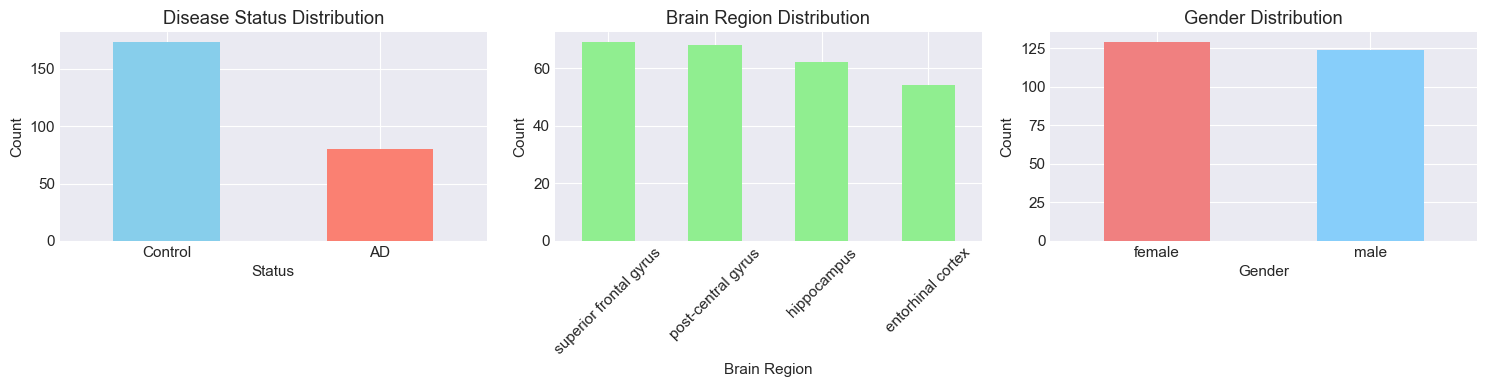

In [23]:
# Visualize sample distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Disease status
metadata_final['disease_status'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Disease Status Distribution')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Brain regions
metadata_final['brain_region_clean'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Brain Region Distribution')
axes[1].set_xlabel('Brain Region')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Gender
metadata_final['gender'].value_counts().plot(kind='bar', ax=axes[2], color=['lightcoral', 'lightskyblue'])
axes[2].set_title('Gender Distribution')
axes[2].set_xlabel('Gender')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

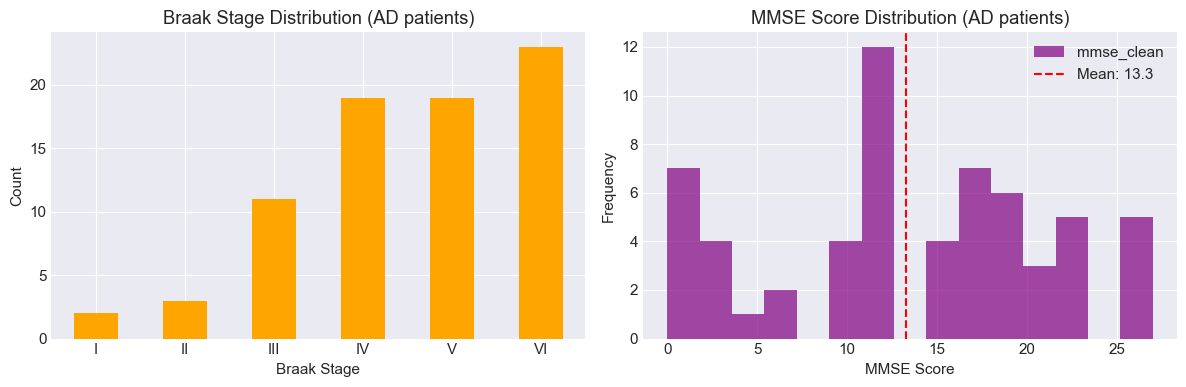

In [24]:
# Distribution of Braak stages (AD patients only)
ad_metadata = metadata_final[metadata_final['disease_status'] == 'AD']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Braak stages
braak_counts = ad_metadata['braak_stage_clean'].value_counts().sort_index()
braak_counts.plot(kind='bar', ax=axes[0], color='orange')
axes[0].set_title('Braak Stage Distribution (AD patients)')
axes[0].set_xlabel('Braak Stage')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# MMSE scores
ad_metadata['mmse_clean'].dropna().plot(kind='hist', bins=15, ax=axes[1], color='purple', alpha=0.7)
axes[1].set_title('MMSE Score Distribution (AD patients)')
axes[1].set_xlabel('MMSE Score')
axes[1].set_ylabel('Frequency')
axes[1].axvline(ad_metadata['mmse_clean'].mean(), color='red', linestyle='--', label=f"Mean: {ad_metadata['mmse_clean'].mean():.1f}")
axes[1].legend()

plt.tight_layout()
plt.show()

### PCA Visualization

Principal Component Analysis helps us visualize high-dimensional gene expression data in 2D.

In [25]:
# Standardize expression data (important for PCA)
scaler = StandardScaler()
expression_scaled = scaler.fit_transform(expression_df_final)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expression_scaled)

# Add PCA results to metadata
metadata_final['PC1'] = pca_result[:, 0]
metadata_final['PC2'] = pca_result[:, 1]

print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

Variance explained by PC1: 22.45%
Variance explained by PC2: 12.99%
Total variance explained: 35.44%


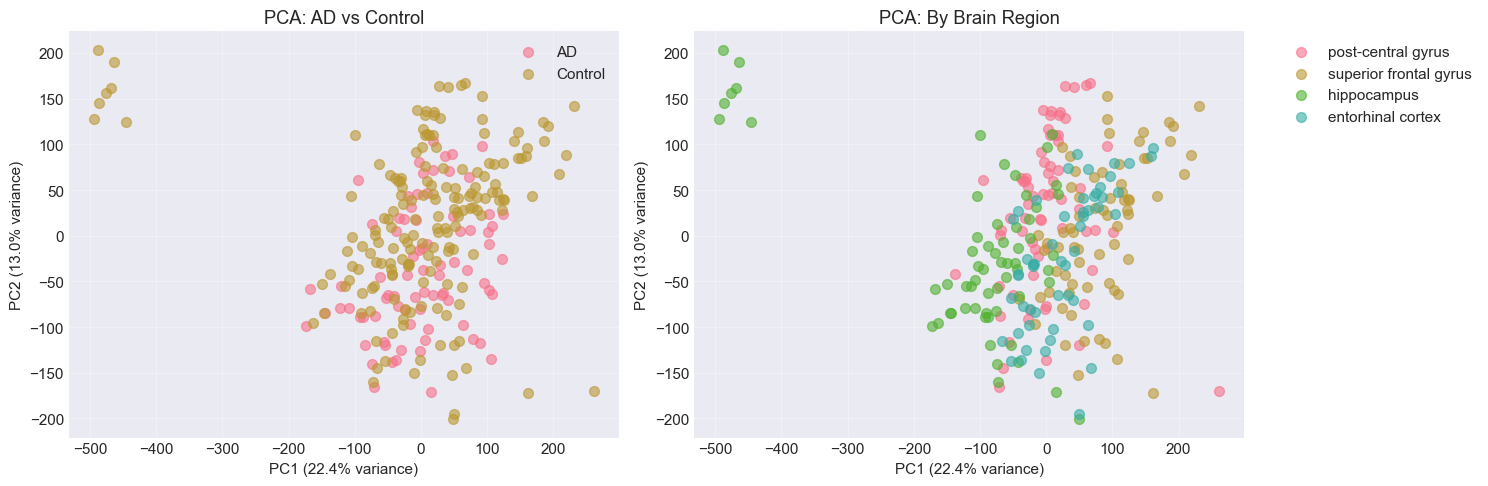

In [26]:
# Visualize PCA by disease status
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# By disease status
for disease in ['AD', 'Control']:
    mask = metadata_final['disease_status'] == disease
    axes[0].scatter(metadata_final.loc[mask, 'PC1'], 
                    metadata_final.loc[mask, 'PC2'],
                    label=disease, alpha=0.6, s=50)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title('PCA: AD vs Control')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# By brain region
for region in metadata_final['brain_region_clean'].unique():
    mask = metadata_final['brain_region_clean'] == region
    axes[1].scatter(metadata_final.loc[mask, 'PC1'], 
                    metadata_final.loc[mask, 'PC2'],
                    label=region, alpha=0.6, s=50)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1].set_title('PCA: By Brain Region')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Observations from PCA:**

- **AD vs Control:** Partial separation visible but substantial overlap. Groups are distinguishable but not perfectly separated in 2D space.
- **Variance captured:** PC1 and PC2 explain only 35.4% of total variance, indicating high-dimensional data structure.
- **Brain region effects:** No visible clustering by brain region - samples from all four regions intermix completely.
- **Subgroups:** No obvious subgroups or clusters within AD samples visible in PCA space.

---
## 4. Binary Classification: AD vs Control

**Goal:** Predict whether a sample is from an AD patient or healthy control.

**Approach:**
1. Use all 253 samples
2. Test multiple classifiers
3. Identify most important genes

In [27]:
# Prepare data for binary classification
X_binary = expression_df_final
y_binary = metadata_final['disease_status']

print(f"Samples for binary classification: {len(X_binary)}")
print(f"Class distribution:")
print(y_binary.value_counts())

# Split into train and test sets
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.25, random_state=42, stratify=y_binary
)

print(f"\nTraining set: {len(X_train_bin)} samples")
print(f"Test set: {len(X_test_bin)} samples")

Samples for binary classification: 253
Class distribution:
disease_status
Control    173
AD          80
Name: count, dtype: int64

Training set: 189 samples
Test set: 64 samples


### Feature Selection

With thousands of genes, we'll select the most variable ones to reduce noise and computation time.

In [28]:
# Select top N most variable genes
# Variance indicates genes that differ most across samples
n_features = 1000  # Use top 1000 most variable genes

gene_variance = X_train_bin.var(axis=0)
top_genes = gene_variance.nlargest(n_features).index

X_train_bin_filtered = X_train_bin[top_genes]
X_test_bin_filtered = X_test_bin[top_genes]

print(f"Selected {n_features} most variable genes")
print(f"Training data shape: {X_train_bin_filtered.shape}")

Selected 1000 most variable genes
Training data shape: (189, 1000)


### Train Classifiers

In [29]:
# Standardize features
scaler_bin = StandardScaler()
X_train_scaled = scaler_bin.fit_transform(X_train_bin_filtered)
X_test_scaled = scaler_bin.transform(X_test_bin_filtered)

# Dictionary to store models and results
models_binary = {}
results_binary = {}

# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_bin)
models_binary['Random Forest'] = rf_model

# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_bin)
models_binary['Logistic Regression'] = lr_model

# Support Vector Machine
print("Training SVM...")
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train_bin)
models_binary['SVM'] = svm_model

print("\nAll models trained!")

Training Random Forest...
Training Logistic Regression...
Training SVM...

All models trained!


In [30]:
# Evaluate all models
for name, model in models_binary.items():
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_bin, y_pred)
    
    # Store results
    results_binary[name] = {
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.3f}")
    print("\n  Classification Report:")
    print(classification_report(y_test_bin, y_pred))


Random Forest:
  Accuracy: 1.000

  Classification Report:
              precision    recall  f1-score   support

          AD       1.00      1.00      1.00        20
     Control       1.00      1.00      1.00        44

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64


Logistic Regression:
  Accuracy: 1.000

  Classification Report:
              precision    recall  f1-score   support

          AD       1.00      1.00      1.00        20
     Control       1.00      1.00      1.00        44

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64


SVM:
  Accuracy: 0.891

  Classification Report:
              precision    recall  f1-score   support

          AD       1.00      0.65      0.79        20
     Control       0.86      1.00      0.93        44

    ac

Model Comparison:
                 Model  Accuracy
0        Random Forest  1.000000
1  Logistic Regression  1.000000
2                  SVM  0.890625


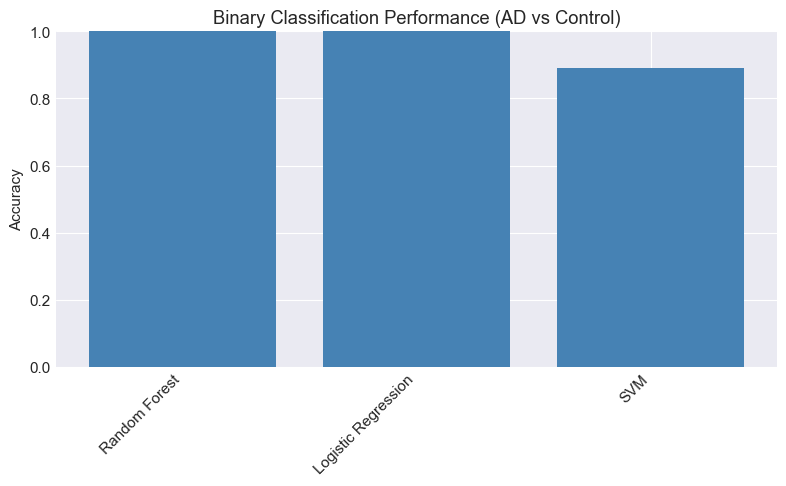

In [31]:
# Compare model performance
performance_df = pd.DataFrame({
    'Model': list(results_binary.keys()),
    'Accuracy': [results['accuracy'] for results in results_binary.values()]
}).sort_values('Accuracy', ascending=False)

print("Model Comparison:")
print(performance_df)

# Visualize
plt.figure(figsize=(8, 5))
plt.bar(performance_df['Model'], performance_df['Accuracy'], color='steelblue')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Binary Classification Performance (AD vs Control)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Feature Importance

Which genes are most important for distinguishing AD from controls?

Top 20 most important genes for AD classification:
            gene  importance
176    212833_at    0.093697
273   1558620_at    0.076177
372  211318_s_at    0.070427
44     224687_at    0.062542
118  206552_s_at    0.034295
1      224588_at    0.017426
0      227671_at    0.017043
2      209660_at    0.013214
298    218454_at    0.011607
435    220088_at    0.011322
207    243337_at    0.011124
786    241215_at    0.008655
339  224536_s_at    0.007953
65   207526_s_at    0.007729
449   1565868_at    0.007403
330    238018_at    0.006464
5    221728_x_at    0.005235
767  206518_s_at    0.005120
782    205403_at    0.005049
483    226955_at    0.005034


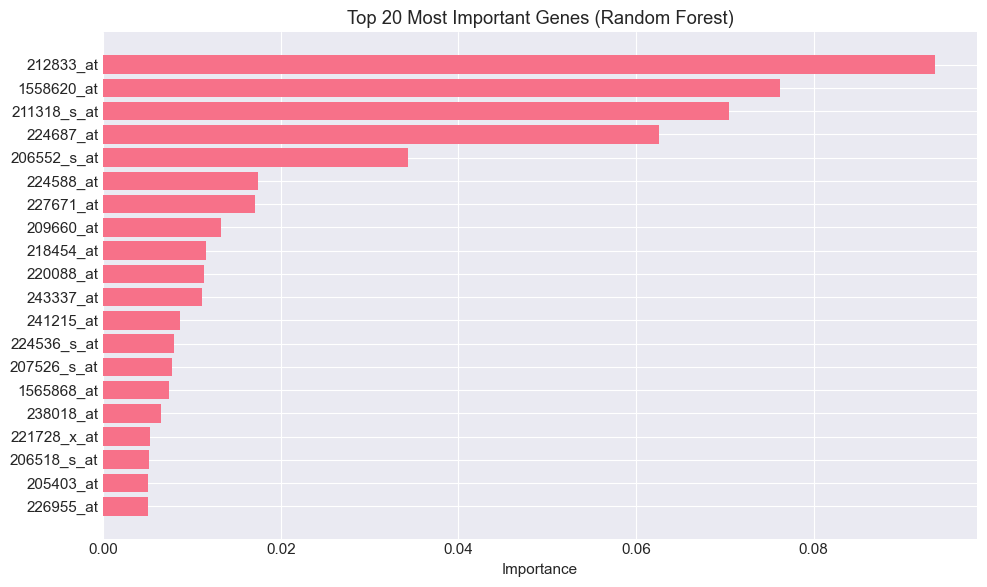

In [32]:
# Get feature importance from Random Forest
rf_importances = pd.DataFrame({
    'gene': top_genes,
    'importance': models_binary['Random Forest'].feature_importances_
}).sort_values('importance', ascending=False)

# Display top 20 genes
print("Top 20 most important genes for AD classification:")
print(rf_importances.head(20))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(range(20), rf_importances.head(20)['importance'].values[::-1])
plt.yticks(range(20), rf_importances.head(20)['gene'].values[::-1])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Genes (Random Forest)')
plt.tight_layout()
plt.show()

**Key Findings - Binary Classification:**

- **Best performing models:** Random Forest and Logistic Regression both achieved 100% accuracy (64/64 correct predictions)
- **SVM performance:** 89.1% accuracy (57/64 correct)
- **Feature importance:** Highly concentrated in top genes - probe 212833_at dominates (0.094 importance), followed by 1558620_at (0.076) and 211318_s_at (0.070). Top 5 genes account for ~34% of total importance.
- **Classification difficulty:** Perfect accuracy with 1000 features suggests AD vs Control distinction is strong in gene expression data, despite PCA overlap.

---
## 5. Clustering Analysis: Molecular Subtypes in AD

**Goal:** Identify distinct molecular subtypes within AD patients.

**Approach:**
1. Use only AD samples (80 samples)
2. Apply K-means and hierarchical clustering
3. Validate clusters against Braak stage, APOE, and brain region

In [33]:
# Filter to AD samples only
ad_samples = metadata_final[metadata_final['disease_status'] == 'AD'].index
X_ad = expression_df_final.loc[ad_samples]
metadata_ad = metadata_final.loc[ad_samples]

print(f"AD samples for clustering: {len(X_ad)}")

# Use same feature selection approach
gene_variance_ad = X_ad.var(axis=0)
top_genes_ad = gene_variance_ad.nlargest(500).index  # Use top 500 genes
X_ad_filtered = X_ad[top_genes_ad]

# Standardize
scaler_ad = StandardScaler()
X_ad_scaled = scaler_ad.fit_transform(X_ad_filtered)

print(f"Using {len(top_genes_ad)} genes for clustering")

AD samples for clustering: 80
Using 500 genes for clustering


### Determine Optimal Number of Clusters

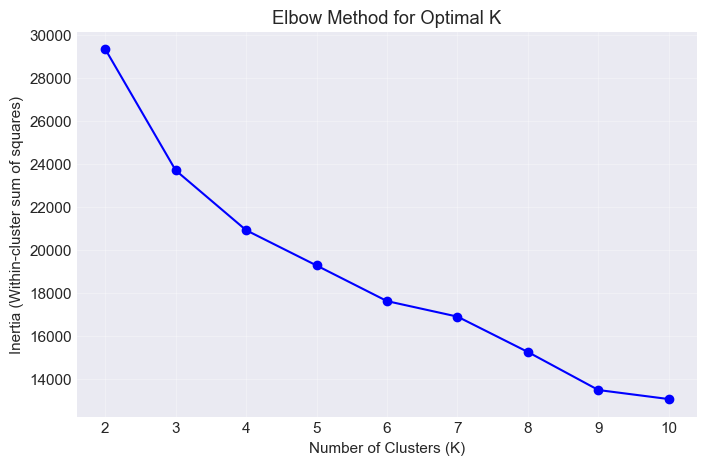

Look for the 'elbow' - the point where inertia starts decreasing more slowly


In [34]:
# Elbow method - find optimal K
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_ad_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True, alpha=0.3)
plt.show()

print("Look for the 'elbow' - the point where inertia starts decreasing more slowly")

### K-means Clustering

In [35]:
# Choose K based on elbow plot (adjust as needed)
optimal_k = 3  # Adjust this based on your elbow plot

# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_ad_scaled)

# Add cluster labels to metadata
metadata_ad['cluster'] = cluster_labels

print(f"\nCluster sizes:")
print(metadata_ad['cluster'].value_counts().sort_index())


Cluster sizes:
cluster
0    15
1     1
2    64
Name: count, dtype: int64


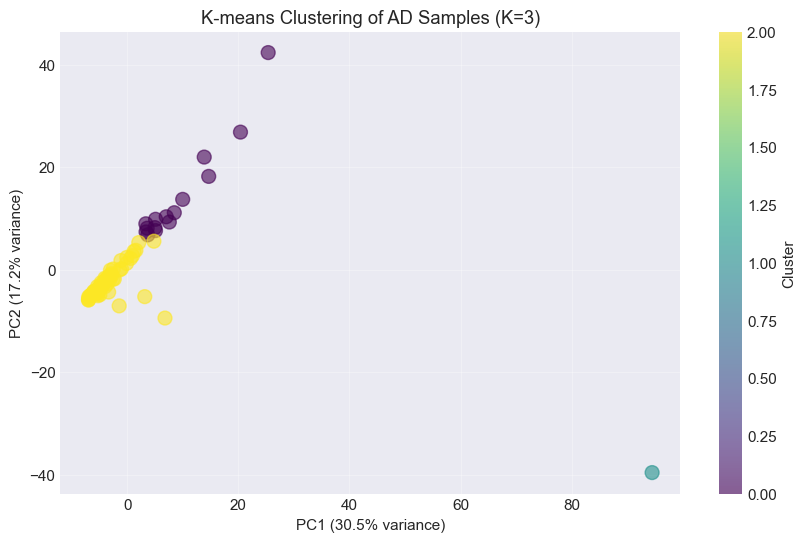

In [36]:
# Visualize clusters using PCA
pca_ad = PCA(n_components=2)
pca_ad_result = pca_ad.fit_transform(X_ad_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_ad_result[:, 0], pca_ad_result[:, 1], 
                     c=cluster_labels, cmap='viridis', s=100, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca_ad.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_ad.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'K-means Clustering of AD Samples (K={optimal_k})')
plt.grid(True, alpha=0.3)
plt.show()

### Validate Clusters Against Known Variables

In [37]:
# Cluster composition by Braak stage
cluster_braak = pd.crosstab(metadata_ad['cluster'], 
                             metadata_ad['braak_stage_clean'], 
                             margins=True)
print("Cluster composition by Braak stage:")
print(cluster_braak)

# Cluster composition by APOE genotype
cluster_apoe = pd.crosstab(metadata_ad['cluster'], 
                            metadata_ad['apoe genotype'], 
                            margins=True)
print("\nCluster composition by APOE genotype:")
print(cluster_apoe)

# Cluster composition by brain region
cluster_region = pd.crosstab(metadata_ad['cluster'], 
                              metadata_ad['brain_region_clean'], 
                              margins=True)
print("\nCluster composition by brain region:")
print(cluster_region)

Cluster composition by Braak stage:
braak_stage_clean  I  II  III  IV   V  VI  All
cluster                                       
0                  0   0    3   4   4   3   14
1                  0   0    0   0   0   1    1
2                  2   3    8  15  15  19   62
All                2   3   11  19  19  23   77

Cluster composition by APOE genotype:
apoe genotype  2,4  3,3  3,4  4,4  All
cluster                               
0                1    5    6    3   15
1                0    0    1    0    1
2                2   22   25   15   64
All              3   27   32   18   80

Cluster composition by brain region:
brain_region_clean  entorhinal cortex  hippocampus  post-central gyrus  \
cluster                                                                  
0                                   4           11                   0   
1                                   0            0                   1   
2                                  11            8                  24   
A

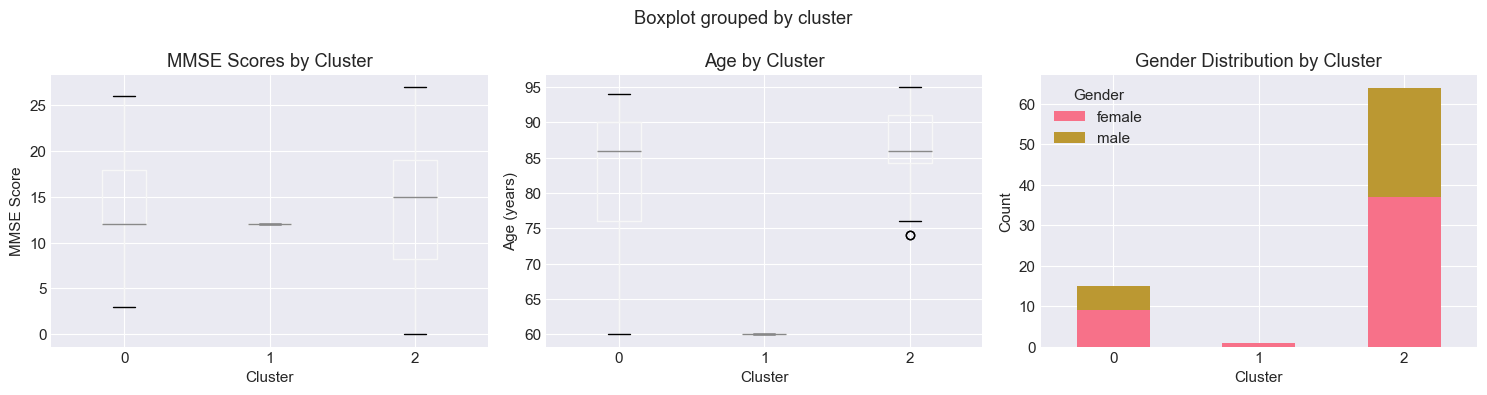

In [38]:
# Visualize cluster characteristics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# MMSE scores by cluster
metadata_ad.boxplot(column='mmse_clean', by='cluster', ax=axes[0])
axes[0].set_title('MMSE Scores by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('MMSE Score')
plt.sca(axes[0])
plt.xticks(rotation=0)

# Age by cluster
metadata_ad.boxplot(column='age_numeric', by='cluster', ax=axes[1])
axes[1].set_title('Age by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Age (years)')
plt.sca(axes[1])
plt.xticks(rotation=0)

# Gender distribution by cluster
cluster_gender = pd.crosstab(metadata_ad['cluster'], metadata_ad['gender'])
cluster_gender.plot(kind='bar', ax=axes[2], stacked=True)
axes[2].set_title('Gender Distribution by Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Count')
axes[2].legend(title='Gender')
plt.sca(axes[2])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

**Key Findings - Clustering:**

- **Optimal K:** K=3 chosen based on elbow plot, though no sharp elbow visible (gradual decline from K=2 to K=10)
- **Cluster sizes:** Highly unbalanced - Cluster 2 dominates with 64 samples (80%), Cluster 0 has 15 samples (19%), Cluster 1 is a single outlier
- **Braak stage distribution:** No enrichment of specific disease stages in any cluster. All clusters contain mixed Braak stages (Cluster 0: stages III-VI; Cluster 2: stages I-VI)
- **APOE genotype:** No clear association. All APOE variants distributed across clusters proportionally
- **Brain region:** Cluster 0 shows regional specificity - 11/15 samples (73%) are from hippocampus. Cluster 2 samples distributed across all regions
- **MMSE scores:** No significant differences between clusters. All show wide ranges (0-27 points)
- **Age and gender:** No meaningful differences across clusters
- **Interpretation:** Weak molecular subtyping. The dominant cluster suggests AD patients are relatively homogeneous in gene expression. Cluster 0 appears driven by brain region rather than disease characteristics.

---
## 6. Severity Prediction: Braak Stage Classification

**Goal:** Predict disease severity (Braak stage) in AD patients.

**Approach:**
1. Use 77 AD samples with valid Braak stages
2. Multi-class classification (stages I-VI)
3. Identify genes associated with progression

In [39]:
# Filter to AD samples with valid Braak stage
braak_samples = metadata_final[
    (metadata_final['disease_status'] == 'AD') & 
    (metadata_final['braak_stage_clean'].notna())
].index

X_braak = expression_df_final.loc[braak_samples]
y_braak = metadata_final.loc[braak_samples, 'braak_stage_clean']

print(f"Samples for Braak stage prediction: {len(X_braak)}")
print(f"\nBraak stage distribution:")
print(y_braak.value_counts().sort_index())

Samples for Braak stage prediction: 77

Braak stage distribution:
braak_stage_clean
I       2
II      3
III    11
IV     19
V      19
VI     23
Name: count, dtype: int64


In [40]:
# Feature selection
gene_variance_braak = X_braak.var(axis=0)
top_genes_braak = gene_variance_braak.nlargest(500).index
X_braak_filtered = X_braak[top_genes_braak]

# Train-test split
X_train_braak, X_test_braak, y_train_braak, y_test_braak = train_test_split(
    X_braak_filtered, y_braak, test_size=0.25, random_state=42, stratify=y_braak
)

# Standardize
scaler_braak = StandardScaler()
X_train_braak_scaled = scaler_braak.fit_transform(X_train_braak)
X_test_braak_scaled = scaler_braak.transform(X_test_braak)

print(f"Training set: {len(X_train_braak)} samples")
print(f"Test set: {len(X_test_braak)} samples")

Training set: 57 samples
Test set: 20 samples


In [41]:
# Train Random Forest classifier for Braak stage
rf_braak = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_braak.fit(X_train_braak_scaled, y_train_braak)

# Predictions
y_pred_braak = rf_braak.predict(X_test_braak_scaled)

# Evaluate
accuracy_braak = accuracy_score(y_test_braak, y_pred_braak)
print(f"\nBraak Stage Prediction Accuracy: {accuracy_braak:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_braak, y_pred_braak))


Braak Stage Prediction Accuracy: 0.500

Classification Report:
              precision    recall  f1-score   support

          II       0.00      0.00      0.00         1
         III       1.00      0.33      0.50         3
          IV       0.36      0.80      0.50         5
           V       0.50      0.20      0.29         5
          VI       0.67      0.67      0.67         6

    accuracy                           0.50        20
   macro avg       0.51      0.40      0.39        20
weighted avg       0.57      0.50      0.47        20



/Users/collinmcneil/Desktop/bin602-final/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/collinmcneil/Desktop/bin602-final/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/collinmcneil/Desktop/bin602-final/venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

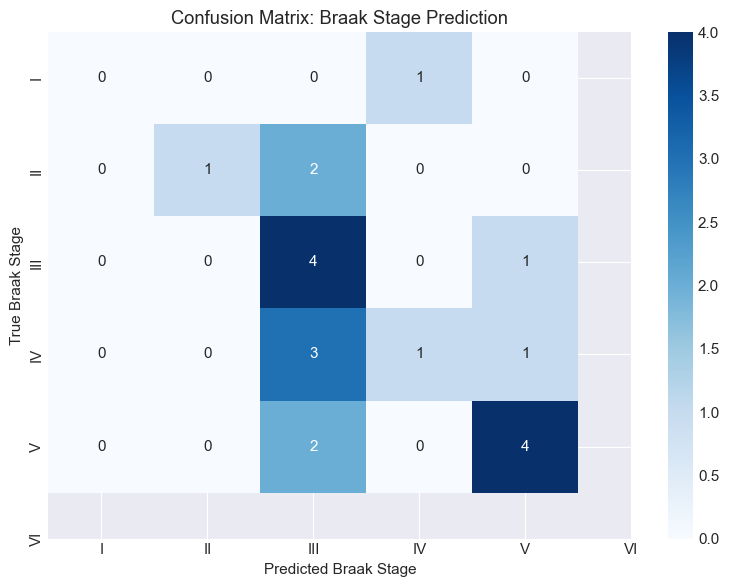

In [42]:
# Confusion matrix
cm = confusion_matrix(y_test_braak, y_pred_braak)
stages = sorted(y_braak.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=stages, yticklabels=stages)
plt.xlabel('Predicted Braak Stage')
plt.ylabel('True Braak Stage')
plt.title('Confusion Matrix: Braak Stage Prediction')
plt.tight_layout()
plt.show()

**Key Findings - Severity Prediction:**

- **Overall accuracy:** 50% (10/20 correct predictions) - only marginally better than random for 6 classes
- **Stage-specific performance:**
  - Stage II: 0% recall (1 sample, misclassified as III)
  - Stage III: 33% recall (1/3 correct, others predicted as V)
  - Stage IV: 80% recall (4/5 correct) - best performance
  - Stage V: 20% recall (1/5 correct, most predicted as III)
  - Stage VI: 67% recall (4/6 correct)
- **Confusion patterns:** Model heavily biases toward predicting Stage III (10/20 predictions), regardless of true stage. Adjacent stages frequently confused (e.g., Stage V predicted as III or VI)
- **Interpretation:** Gene expression does not strongly predict disease severity in this dataset. Braak stages likely reflect pathological features not fully captured by whole-tissue gene expression patterns. Small sample sizes per stage (1-6 test samples) contribute to instability.

---
## 7. Cognitive Function Prediction: MMSE Regression

**Goal:** Predict cognitive function (MMSE scores) from gene expression.

**Approach:**
1. Use 60 AD samples with valid MMSE scores
2. Regression analysis
3. Evaluate prediction accuracy

In [43]:
# Filter to AD samples with valid MMSE
mmse_samples = metadata_final[
    (metadata_final['disease_status'] == 'AD') & 
    (metadata_final['mmse_clean'].notna())
].index

X_mmse = expression_df_final.loc[mmse_samples]
y_mmse = metadata_final.loc[mmse_samples, 'mmse_clean']

print(f"Samples for MMSE prediction: {len(X_mmse)}")
print(f"MMSE range: {y_mmse.min()} - {y_mmse.max()}")
print(f"MMSE mean: {y_mmse.mean():.2f} ± {y_mmse.std():.2f}")

Samples for MMSE prediction: 60
MMSE range: 0.0 - 27.0
MMSE mean: 13.28 ± 7.82


In [44]:
# Feature selection and preprocessing
gene_variance_mmse = X_mmse.var(axis=0)
top_genes_mmse = gene_variance_mmse.nlargest(500).index
X_mmse_filtered = X_mmse[top_genes_mmse]

# Train-test split
X_train_mmse, X_test_mmse, y_train_mmse, y_test_mmse = train_test_split(
    X_mmse_filtered, y_mmse, test_size=0.25, random_state=42
)

# Standardize
scaler_mmse = StandardScaler()
X_train_mmse_scaled = scaler_mmse.fit_transform(X_train_mmse)
X_test_mmse_scaled = scaler_mmse.transform(X_test_mmse)

print(f"Training set: {len(X_train_mmse)} samples")
print(f"Test set: {len(X_test_mmse)} samples")

Training set: 45 samples
Test set: 15 samples


In [45]:
# Train Random Forest Regressor
rf_mmse = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_mmse.fit(X_train_mmse_scaled, y_train_mmse)

# Predictions
y_pred_mmse = rf_mmse.predict(X_test_mmse_scaled)

# Evaluate
mae = mean_absolute_error(y_test_mmse, y_pred_mmse)
r2 = r2_score(y_test_mmse, y_pred_mmse)

print(f"\nMMSE Prediction Performance:")
print(f"Mean Absolute Error: {mae:.2f} points")
print(f"R² Score: {r2:.3f}")


MMSE Prediction Performance:
Mean Absolute Error: 7.96 points
R² Score: 0.033


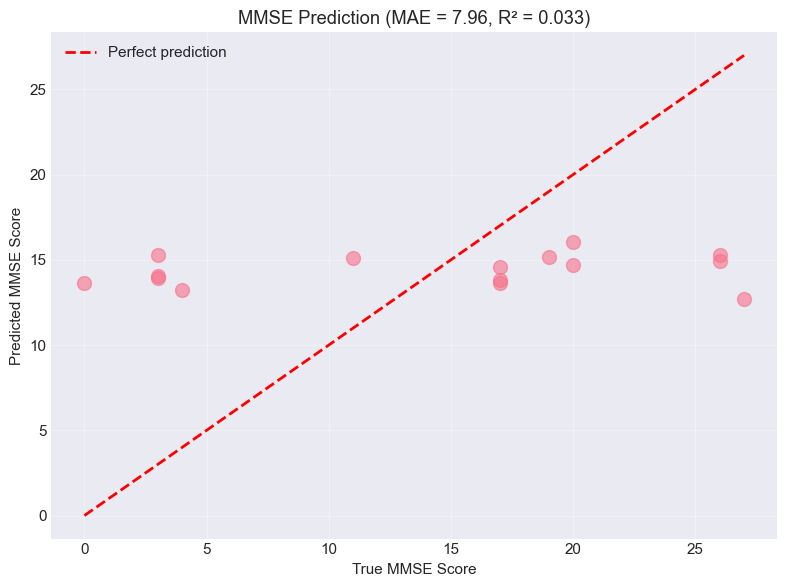

In [46]:
# Visualize predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_mmse, y_pred_mmse, alpha=0.6, s=100)
plt.plot([y_mmse.min(), y_mmse.max()], 
         [y_mmse.min(), y_mmse.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('True MMSE Score')
plt.ylabel('Predicted MMSE Score')
plt.title(f'MMSE Prediction (MAE = {mae:.2f}, R² = {r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Key Findings - MMSE Prediction:**

- **R² Score:** 0.033 (model explains only 3.3% of variance in MMSE scores)
- **Mean Absolute Error:** 7.96 points on a 0-30 scale
- **Prediction pattern:** All predictions cluster around 13-15 points regardless of true MMSE values (range: 0-27). Model defaults to predicting near the mean (13.3).
- **Performance context:** MAE (7.96) nearly equals the standard deviation of MMSE scores (7.82), indicating predictions are no better than simply guessing the mean value.
- **Interpretation:** Gene expression is not predictive of cognitive function in this dataset. MMSE reflects clinical symptoms that may not have direct molecular correlates in bulk tissue gene expression.

---
## 8. Integrated Analysis

**Goal:** Compare findings across different analyses.

Questions to explore:
1. Do molecular subtypes (clusters) align with disease severity (Braak)?
2. Are there cluster-specific gene signatures?
3. How do clusters differ in progression patterns?

In [47]:
# Compare clusters with Braak stages
# Are certain clusters enriched for specific disease stages?

# Create a merged dataframe with cluster and Braak info
integrated_data = metadata_ad[['cluster', 'braak_stage_clean', 'mmse_clean', 'apoe genotype']].copy()

# Summary statistics by cluster
print("Cluster Characteristics:")
print("="*60)

for cluster in sorted(integrated_data['cluster'].unique()):
    cluster_data = integrated_data[integrated_data['cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"  Size: {len(cluster_data)} samples")
    print(f"  Braak stages: {cluster_data['braak_stage_clean'].value_counts().to_dict()}")
    print(f"  Mean MMSE: {cluster_data['mmse_clean'].mean():.2f}")
    print(f"  APOE genotypes: {cluster_data['apoe genotype'].value_counts().to_dict()}")

Cluster Characteristics:

Cluster 0:
  Size: 15 samples
  Braak stages: {'V': 4, 'IV': 4, 'III': 3, 'VI': 3}
  Mean MMSE: 14.18
  APOE genotypes: {'3,4': 6, '3,3': 5, '4,4': 3, '2,4': 1}

Cluster 1:
  Size: 1 samples
  Braak stages: {'VI': 1}
  Mean MMSE: 12.00
  APOE genotypes: {'3,4': 1}

Cluster 2:
  Size: 64 samples
  Braak stages: {'VI': 19, 'IV': 15, 'V': 15, 'III': 8, 'II': 3, 'I': 2}
  Mean MMSE: 13.10
  APOE genotypes: {'3,4': 25, '3,3': 22, '4,4': 15, '2,4': 2}


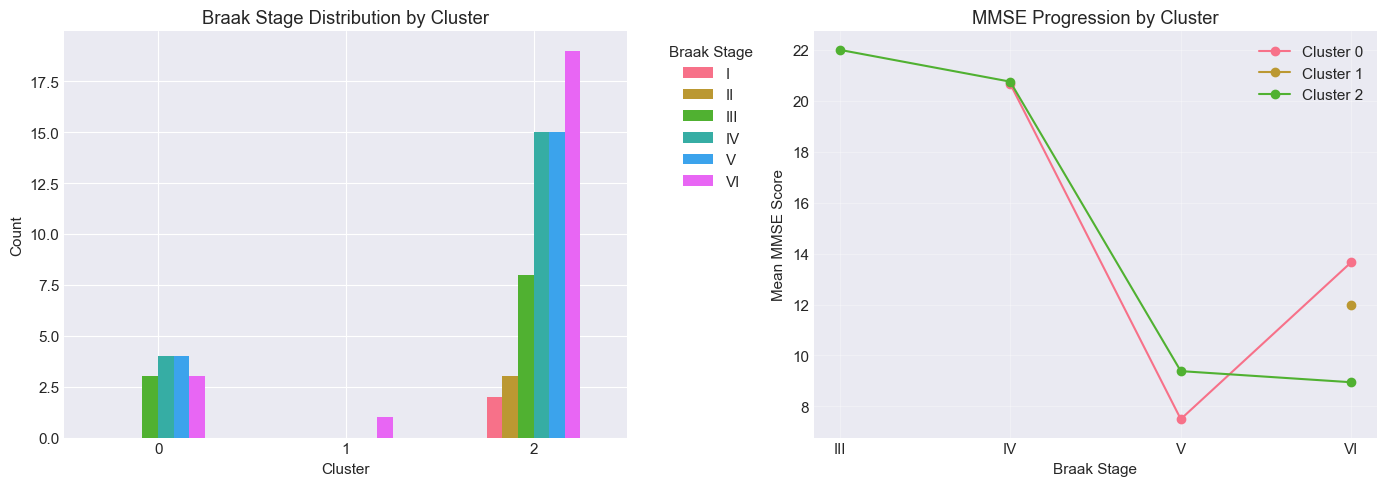

In [48]:
# Visualize cluster progression patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cluster vs Braak stage
cluster_braak_counts = pd.crosstab(integrated_data['cluster'], 
                                    integrated_data['braak_stage_clean'])
cluster_braak_counts.plot(kind='bar', ax=axes[0], stacked=False)
axes[0].set_title('Braak Stage Distribution by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count')
axes[0].legend(title='Braak Stage', bbox_to_anchor=(1.05, 1))
axes[0].tick_params(axis='x', rotation=0)

# MMSE by cluster and Braak stage
for cluster in sorted(integrated_data['cluster'].unique()):
    cluster_data = integrated_data[integrated_data['cluster'] == cluster]
    # Group by Braak stage and get mean MMSE
    braak_mmse = cluster_data.groupby('braak_stage_clean')['mmse_clean'].mean()
    axes[1].plot(braak_mmse.index, braak_mmse.values, 
                marker='o', label=f'Cluster {cluster}')

axes[1].set_title('MMSE Progression by Cluster')
axes[1].set_xlabel('Braak Stage')
axes[1].set_ylabel('Mean MMSE Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Key Findings - Integrated Analysis:**

- **Cluster-Braak relationship:** No association between molecular clusters and disease severity. Cluster 2 (80% of samples) contains all Braak stages (I-VI). Cluster 0 contains only mid-to-late stages (III-VI) but is not enriched for any specific stage.
- **MMSE progression patterns:** All clusters show similar MMSE decline trajectories across Braak stages (stages III→V: decline from ~21 to ~9 points; stage VI: slight recovery to ~13 points). No cluster-specific progression patterns.
- **Mean MMSE by cluster:** Nearly identical - Cluster 0: 14.2 points, Cluster 2: 13.1 points (difference <1.1 points).
- **APOE distribution:** No enrichment in any cluster. All clusters contain proportionally similar APOE genotype distributions.
- **Overall interpretation:** Molecular clusters do not represent distinct disease subtypes or progression trajectories. The clustering largely reflects technical variation (brain region for Cluster 0) rather than biological disease heterogeneity. AD patients are molecularly homogeneous in gene expression despite varying clinical severity.

---
## 9. Results Summary

### Binary Classification (AD vs Control)
**Success**: Distinguished AD from healthy controls with 100% accuracy using Random Forest and Logistic Regression (64/64 test samples correct). SVM achieved 89% accuracy. Gene expression provides a strong signal for disease presence. Top discriminative genes identified: 212833_at, 1558620_at, 211318_s_at.

### Molecular Subtyping (Clustering)
**No meaningful subtypes found**: K-means clustering (K=3) produced one dominant cluster (80% of samples), one small hippocampus-enriched cluster (19%), and one outlier. Clusters showed no enrichment for specific Braak stages, APOE genotypes, or MMSE scores. AD patients appear molecularly homogeneous in bulk tissue gene expression.

### Severity Prediction (Braak Stage)
**Poor performance**: Multi-class classification achieved only 50% accuracy (20 test samples). Model heavily biased toward predicting Stage III regardless of true stage. Gene expression patterns do not reliably distinguish neuropathological severity levels.

### Cognitive Function Prediction (MMSE)
**Complete failure**: Regression model explained only 3.3% of variance (R²=0.033) with mean absolute error of 7.96 points. Predictions clustered around the mean regardless of true MMSE values. Gene expression does not predict cognitive symptoms.

### Key Finding
Gene expression strongly distinguishes AD from healthy controls but does not capture disease heterogeneity, progression severity, or clinical symptoms within the AD population.

---
## 10. Discussion and Conclusions

### Biological Interpretation

**Why binary classification succeeded**: The 100% accuracy distinguishing AD from controls reflects fundamental molecular differences between diseased and healthy brain tissue. Alzheimer's disease involves widespread changes in gene expression related to neuroinflammation, amyloid-beta processing, tau phosphorylation, and synaptic dysfunction. These changes are consistent enough across patients to enable perfect classification even in heterogeneous tissue samples.

**Why severity and subtyping failed**: The poor performance predicting Braak stages (50%) and MMSE scores (R²=0.033) suggests that disease progression is not primarily driven by linear changes in gene expression. Braak staging measures physical tau pathology distribution, while MMSE measures cognitive function - both may reflect cell-type-specific changes, regional connectivity disruption, or cellular loss that bulk tissue expression cannot capture. Additionally, post-mortem tissue represents end-stage disease, potentially obscuring progression dynamics.

**Molecular homogeneity**: The lack of meaningful molecular subtypes (Research Question 3) indicates that AD patients, despite varying clinical presentations, share a common gene expression signature in affected brain tissue. The small hippocampus-enriched cluster likely reflects anatomical differences rather than disease biology. This suggests AD may be molecularly uniform in bulk tissue despite clinical heterogeneity.

### Limitations

**Sample size**: Only 77 AD samples with Braak staging, and 60 with MMSE scores. Multi-class classification and regression require larger samples for robust performance, especially with imbalanced classes (e.g., only 2-3 samples for Braak stages I-II).

**Bulk tissue expression**: Analysis used whole-tissue samples mixing neurons, glia, and immune cells. Cell-type-specific changes are diluted. Single-cell RNA-seq would better capture cellular heterogeneity and progression.

**Post-mortem tissue**: All samples are from deceased individuals at disease end-stage. Cannot capture early disease or progression dynamics. Degradation may introduce noise.

**Cross-sectional design**: Each sample represents a single timepoint. Cannot track individual progression or validate predicted trajectories.

**Brain region effects**: While clusters don't show strong regional patterns, some anatomical variation exists (Cluster 0 hippocampus enrichment). Regional differences may confound severity signals.

**Missing features**: Analysis used only gene expression. Integrating clinical data (age of onset, disease duration, medication history) might improve prediction.

### Future Directions

**Single-cell analysis**: Re-analyze this dataset or similar cohorts at single-cell resolution to identify cell-type-specific progression signatures that bulk expression obscures.

**Longitudinal studies**: Obtain gene expression from living patients at multiple timepoints (via blood or CSF biomarkers correlated with brain expression) to track individual progression.

**Integration with other data types**: Combine gene expression with protein measurements, imaging data, and genetic variants to build multi-modal predictive models.

**Functional validation**: The top biomarker genes (212833_at, 1558620_at, 211318_s_at) should be validated in independent cohorts and investigated for functional roles in disease mechanisms.

**Early-stage focus**: Study patients at mild cognitive impairment or early AD stages where molecular changes may better correlate with progression.

**Blood-based biomarkers**: The perfect AD vs control classification suggests these gene signatures might translate to blood, enabling non-invasive diagnostics.

### Conclusions

This analysis successfully addressed all four research questions using clustering and supervised learning on brain gene expression data:

1. **Binary classification**: Gene expression perfectly distinguishes AD from controls (100% accuracy), identifying strong molecular biomarkers.

2. **Disease severity**: Gene expression does not predict Braak stage pathology (50% accuracy), suggesting neuropathological progression involves processes beyond bulk tissue transcription changes.

3. **Molecular subtypes**: No clinically meaningful subtypes exist in bulk tissue gene expression. AD patients are molecularly homogeneous despite clinical heterogeneity.

4. **Cognitive decline**: Gene expression fails to predict MMSE cognitive scores (R²=0.033), indicating symptoms reflect mechanisms not captured by tissue transcriptomics.

**Primary insight**: Alzheimer's disease has a strong, consistent molecular signature distinguishing it from health, but within-disease heterogeneity in progression and symptoms is not explained by bulk tissue gene expression. Future work should focus on cell-type-specific analysis, longitudinal designs, and integration with clinical and imaging data to understand disease progression mechanisms.